## Facial Keypoints Detection

- about competition: https://www.kaggle.com/c/facial-keypoints-detection
- data: https://www.kaggle.com/c/facial-keypoints-detection/data
- leaderboard: https://www.kaggle.com/c/facial-keypoints-detection/leaderboard
- my best submission: https://www.kaggle.com/c/facial-keypoints-detection/leaderboard?submissionId=3447273 RMSE 2.90701
- thanks to http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
import theano
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator
import cPickle as pickle
import sys
import matplotlib.pyplot as plt

%matplotlib inline

Get data

In [2]:
df_train_src = pd.read_csv('data/training.csv')
df_test_src = pd.read_csv('data/test.csv')

print df_train_src.info()
df_train_src.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


Drop rows with missing values (TODO deal with them later)

In [3]:
df_train = df_train_src.copy(deep=True)
df_train.dropna(inplace=True)
print "{} observations left out of {}".format(len(df_train), len(df_train_src))

2140 observations left out of 7049


Prepare data for neural network
features (image):
- split the Image column (space separated values like "238 236 237 238...") into
- scale the pixels from [0-255] to [0-1] (just divide by 255)
- make it a 3D array; each image is 1 (grayscale only) x 96 x 96 for convolutional network
target:
- scale coordinates to [-1,1]

In [4]:
def create_xy(df, train):
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' ')) # make image an array
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    # need 3-d array for convolutional layers
    X = X.reshape(-1, 1, 96, 96) # (rows, colors, pixels_x, pixels_y), -1 will be derived
    
    if train:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

X, y = create_xy(df_train, train=True)
X_test, _ = create_xy(df_test_src, train=False)

print "shape of features: {}".format(X.shape)
print "shape of target: {}".format(y.shape)

shape of features: (2140, 1, 96, 96)
shape of target: (2140, 30)


Visualize data

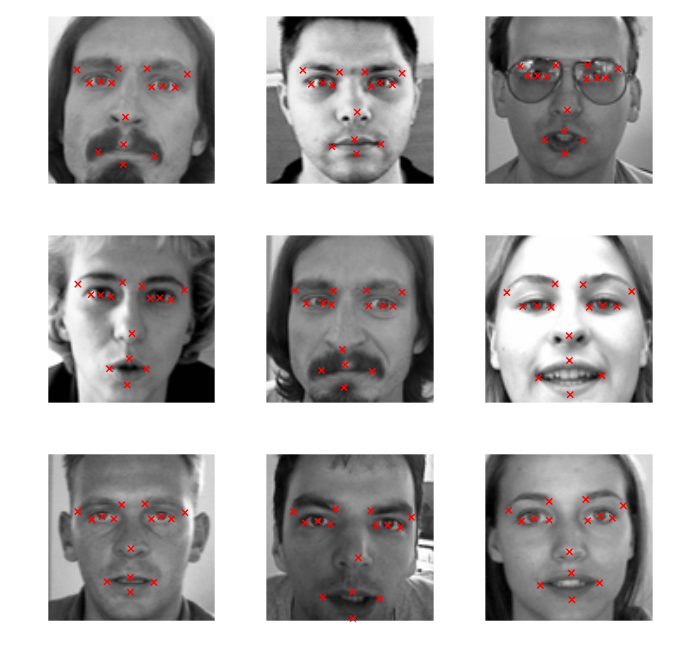

In [5]:
def plot_samples(X, y, samples=3):
    idx = 0
    for x in xrange(samples):
        for z in xrange(samples):
            f = plt.figure(samples*samples)
            f.set_figheight(8)
            f.set_figwidth(8)
            plt_idx = z * samples + x + 1
            plt.subplot(samples, samples, plt_idx)
            plt.imshow(X[idx].reshape(96, 96).astype(float), cmap='gray')
            plt.scatter(y[idx][range(0,30,2)]*48+48, y[idx][range(1,30,2)]*48+48, c='r', marker='x')
            plt.axis("off")
            idx += 1
    plt.show()

plot_samples(X, y)

**Convolutional Neural Network**

Data augmentation
- with 50% probability flip the image vertically

In [7]:
class FlipBatchIterator(BatchIterator):
    swap_indices = [
        (0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11), # eyes
        (12, 16), (13, 17), (14, 18), (15, 19), # eyebrows
        (22, 24), (23, 25), # mouth
    ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # flip random half of the images in the batch
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # horizontal flip of all x coordinates
            yb[indices, ::2] = yb[indices, ::2] * -1

            # swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.swap_indices:
                yb[indices, a], yb[indices, b] = (yb[indices, b], yb[indices, a])

        return Xb, yb

Speed up the learning
- update variables (learning rate and momentum)

In [8]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start = start
        self.stop = stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

Define convolutional neural network

In [27]:
nn = NeuralNet(
    # layers
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer), # rectifier: max(0,x)
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters
    input_shape=(None, 1, 96, 96),  # variable batch size, 1 color, 96x96 input pixels
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None, # 30 target values

    # optimization method
    update=nesterov_momentum, # optimized gradient descent, faster than sgd
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,  # regression problem
    batch_iterator_train=FlipBatchIterator(batch_size=128), # flip 50% of images
    on_epoch_finished=[ # speed up learning - update rate and momentum after each epoch
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],    
    max_epochs=15000,  # train this many epochs
    verbose=0,
    )

Fit the convolutional neural network

In [ ]:
nn.fit(X, y)

In [43]:
print "final training loss: {}".format(np.array([i["train_loss"] for i in nn.train_history_])[14999])
print "final validation loss: {}".format(np.array([i["valid_loss"] for i in nn.train_history_])[14999])

final training loss: 0.000677780912989
final validation loss: 0.000432816437972


In [44]:
# assuming same distribution of train and test which is not the case
print 'expected RMSE (assuming same test distribution): {}'.format(np.sqrt(0.00067778091298886269) * 48)

expected RMSE (assuming same test distribution): 1.24964283838


Pickle train nn for further use

In [30]:
# need to change recursion limit, otherwise pickle crashes
sys.setrecursionlimit(10000)
with open('data/nn.pkl', 'wb') as f:
    pickle.dump(nn, f, -1)

Predict and visualize predictions

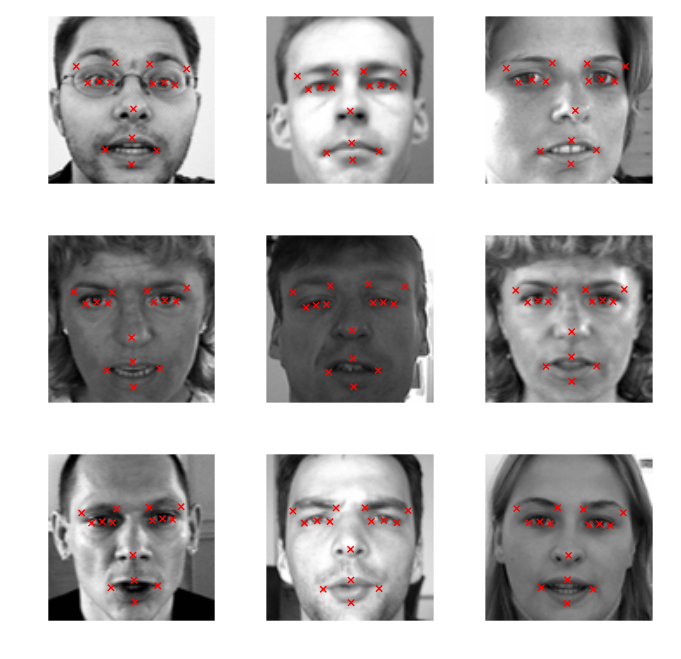

In [45]:
y_pred = nn.predict(X_test)
plot_samples(X_test, y_pred)

Submission

In [47]:
def create_submission(y_pred, columns):
    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = pd.DataFrame(y_pred2, columns=columns)

    lookup_table = pd.read_csv('data/IdLookupTable.csv')
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    return pd.DataFrame(values, columns=('RowId', 'Location'))

submission = create_submission(y_pred=nn.predict(X_test), columns=df_train_src.columns[:-1])
submission.to_csv('submissions/submission_20160918_1009_conv.csv', index=False)